In [2]:
import csv
import time
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from verstack.stratified_continuous_split import scsplit # pip install verstack
from nltk.corpus import stopwords 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import os
import gensim
from gensim.models.doc2vec import Doc2Vec
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 基本思路
使用如下两组要素
- 数字变量
  1. favorites count (log_stand)
  2. followers count (log_stand)
  3. statues count (发推数量) (log_stand)
  4. friends count (log_stand)
  5. urls count (log_stand)
  6. verified (1 or 0) (这一部分我们不做log_stand)
  7. timestamp (一天内的早中晚（hour），距离大选的时间(month和day)，周几(wday)都可能产生影响)
- 文本变量
  1. tweet text
  2. hashtags 

将文本变量通过embedding处理后用CNN/LSTM得到一部分输出，另外对数字变量通过CNN也得到了一部分结果，最后汇总，用2层dense layer。


In [4]:
# Load data
train_data = pd.read_csv("data/train.csv")
eval_data = pd.read_csv("data/evaluation.csv")

# Pre-process the traning data
label = "text"
train_data[label] = train_data[label].map(lambda x: str.split(x, sep=" "))


label = "mentions"
train_data[label+"_count"] = train_data[label].map(lambda x: len(str.split(x)))
mentions = set()
train_data[label].apply(lambda x: mentions.update(x))
print("all mentions in train data: ", mentions)


label = "urls"
train_data[label] = train_data[label].map(lambda x: [] if x=="[]" else [str.strip(url) for url in str.split(x[1:-1], sep=",")])
train_data[label+"_count"] = train_data[label].map(lambda x: len(x))
urls = set()
train_data[label].apply(lambda x: None if len(x)<1 else urls.update(x))
print(f"average number of urls in train data: {train_data.urls_count.mean():1.3f}")
print("number of distinct urls in eval data: ", len(urls))

label = "verified"
print("verified users: ", train_data["verified"].sum())


label = "hashtags"
train_data[label] = train_data[label].map(lambda x: [] if x=="[]" else [str.strip(tag) for tag in str.split(x[1:-1], sep=",")])
train_data[label+"_count"] = train_data[label].map(lambda x: len(x))
hashtags = set()
train_data[label].apply(lambda x: None if len(x)<1 else hashtags.update(x))
print(f"average number of hashtags in train data: {train_data.hashtags_count.mean():1.3f}")
print("number of distinct hashtags in train data:", len(hashtags))


label = "hashtags"
eval_data[label] = eval_data[label].map(lambda x: [] if x=="[]" else [str.strip(tag) for tag in str.split(x[1:-1], sep=",")])
eval_data[label+"_count"] = eval_data[label].map(lambda x: len(x))
hashtags2 = set()
eval_data[label].apply(lambda x: None if not x else hashtags2.update(x))
print(f"average number of hashtags in evaluation data: {eval_data.hashtags_count.mean():1.3f}")
print("number of distinct hashtags in evaluation data:", len(hashtags2))



# Treatment of time
# The time relative to the election (month and yday), day in the week, 
# and the hour all affect the number of retweets.
train_data["time"] = train_data["timestamp"].map(lambda x: time.gmtime(x//1000))
# Only 2380 tweets are not posted in 2022, so we ignore the year
# train_data["year"] = train_data["timestamp"].map(lambda x: x.tm_year)
train_data["month"] = train_data["time"].map(lambda x: x.tm_mon)
train_data["wday"] = train_data["time"].map(lambda x: x.tm_wday)
train_data["hour"] = train_data["time"].map(lambda x: x.tm_hour)
print("number of tweets not posted in 2022 in train data:", len(train_data[train_data.time.map(lambda x: x.tm_year) < 2022]))

# We drop the following data:
# @TweetID: useless
# @mentions: none of the mentions in the train data are not null
# @mentions_count
# @urls: we use urls_count instead

train_data.drop(labels=["TweetID","time", "mentions","mentions_count", "urls"], axis=1, inplace=True)
train_data.head(5)

all mentions in train data:  {']', '['}
average number of urls in train data: 0.529
number of distinct urls in eval data:  185951
verified users:  10621
average number of hashtags in train data: 0.297
number of distinct hashtags in train data: 12093
average number of hashtags in evaluation data: 0.299
number of distinct hashtags in evaluation data: 5942
number of tweets not posted in 2022 in train data: 2380


,text,retweets_count,favorites_count,followers_count,statuses_count,friends_count,verified,hashtags,timestamp,urls_count,hashtags_count,month,wday,hour
0,"[rt, refarcir, macron, ans, nom, prépare]",3,0,3682,453535,3628,0,[],1646978048000,0,0,3,4,5
1,[populaire],0,0,86,1016,284,0,[],1647694288000,0,0,3,5,12
2,"[faut, dégager, cinglé]",3,1,1944,28234,1995,0,[],1647370048000,0,0,3,1,18
3,"[enseignants, mettre, prescriptions, président...",0,0,1,1072,0,0,[],1647256282000,1,0,3,0,11
4,"[mafieuse, oppressive, macron]",0,0,13957,25311,10841,0,[],1647258374000,0,0,3,0,11


In [5]:
# Here we split our training data into trainig and testing set. This way we can estimate the evaluation of our model without uploading to Kaggle and avoid overfitting over our evaluation dataset.
# scsplit method is used in order to split our regression data in a stratisfied way and keep a similar distribution of retweet counts between the two sets
X_train, X_test, y_train, y_test = scsplit(train_data, train_data['retweets_count'], stratify=train_data['retweets_count'], train_size=0.7, test_size=0.3)

# We remove the actual number of retweets from our features since it is the value that we are trying to predict
X_train = X_train.drop(["retweets_count"], axis=1)
X_test = X_test.drop(["retweets_count"], axis=1)

In [6]:
# standardise the columns of numeric values
def standardise(data,list_column):
    for name_column in list_column:
        # standardize
        if data[name_column].std()!=0:
            data[name_column]=(data[name_column]-data[name_column].mean())/data[name_column].std()
        else:
            data[name_column]=(data[name_column]-data[name_column].mean())
            
standardise(X_train,["favorites_count","followers_count","statuses_count","friends_count","urls_count","hashtags_count","verified","timestamp","month","wday","hour"])
standardise(X_test, ["favorites_count","followers_count","statuses_count","friends_count","urls_count","hashtags_count","verified","timestamp","month","wday","hour"])

# split the table into 2 parts: one with the text and the other with the numbers
X_train_num=X_train.drop(["text", "hashtags"], axis=1)
X_test_num=X_test.drop(["text", "hashtags"], axis=1)

X_train_text=X_train[["text", "hashtags"]]
X_test_text=X_test[["text", "hashtags"]]
X_train_num.head(3)

,favorites_count,followers_count,statuses_count,friends_count,verified,timestamp,urls_count,hashtags_count,month,wday,hour
174230,-0.051518,-0.078478,-0.416483,-0.517543,-0.177268,0.019607,0.926573,2.202999,-0.041798,1.041114,-0.049599
236989,-0.053798,-0.035414,0.569586,3.572957,-0.177268,0.022119,0.926573,0.909360,-0.041798,1.041114,0.693400
10890,-0.053798,-0.079921,-0.411123,-0.502250,-0.177268,0.057583,0.926573,-0.384278,-0.041798,-1.767201,0.693400


In [7]:
# This part is used to train the embedding of the vocabulary, only needed to be run once

path_text_dataset='French-Word-Embeddings/Data/data.txt'
text_dataset=pd.read_table(path_text_dataset).values
text_dataset=[item[0][:-1] for item in text_dataset]

TaggedDocument=gensim.models.doc2vec.TaggedDocument

def X_text(sentences):
    X=[]
    for i,text in enumerate(sentences):
        words=text.split(" ")
        l=len(words)
        words=words[:-2]
        document=TaggedDocument(words,tags=[i])
        X.append(document)
    return X

X_documents=X_text(text_dataset)

def train_text(text_train,size=10,epochs=10):
    model=Doc2Vec(text_train,min_count=1,window=3,vector_size=size,sample=1e-3,negative=5,epochs=epochs)
    model.train(text_train,total_examples=model.corpus_count,epochs=model.epochs)
    return model

if not os.path.exists('./WE_models'):
    os.mkdir('./WE_models')

# run only once this part  
# model_text128=train_text(X_documents, size=128)
# model_text128.save('WE_models/d2v_128D')
# model_text64=train_text(X_documents, size=64)
# model_text64.save('WE_models/d2v_64D')
# model_text32=train_text(X_documents, size=32)
# model_text32.save('WE_models/d2v_32D')
# model_text10=train_text(X_documents, size=10)
# model_text10.save('WE_models/d2v_10D')
# model_text5=train_text(X_documents, size=5)
# model_text5.save('WE_models/d2v_5D')

In [8]:
# Here we load the embedding model:
model_text128 = Doc2Vec.load('WE_models/d2v_128D')
# model_text32 = Doc2Vec.load('WE_models/d2v_32D')

In [9]:

# Tranform the textual part to vector

def text2vec(text_train, model, alpha=0.05, min_alpha=0.025, epochs=10, tags=True):
    list_text=[]
    for sentence in text_train:
        vec = model.infer_vector(doc_words=sentence, alpha=alpha, min_alpha=min_alpha, epochs=epochs).tolist()
        list_text.append(vec)
    return np.array(list_text)

# text to vector
X_train_tweet_vec = text2vec(X_train_text["text"], model=model_text128)
train_text_tensor=torch.Tensor(X_train_tweet_vec)
X_test_tweet_vec = text2vec(X_test_text["text"], model=model_text128)
test_text_tensor=torch.Tensor(X_test_tweet_vec)

# hashtags to vector
X_train_tags_vec = text2vec(X_train_text["hashtags"], model=model_text128)
train_tags_tensor=torch.Tensor(X_train_tags_vec)
X_test_tags_vec = text2vec(X_test_text["hashtags"], model=model_text128)
test_tags_tensor=torch.Tensor(X_test_tags_vec)

# combine the two vectors
X_train_text_vec = np.concatenate((X_train_tweet_vec, X_train_tags_vec), axis=1)
X_test_text_vec = np.concatenate((X_test_tweet_vec, X_test_tags_vec), axis=1)

X_train_text_tensor = torch.Tensor(X_train_text_vec)
X_test_text_tensor = torch.Tensor(X_test_text_vec)


In [10]:

X_train_num_vec=X_train_num.values
X_train_num_tensor=torch.Tensor(X_train_num_vec)
X_test_num_vec=X_test_num.values
X_test_num_tensor=torch.Tensor(X_test_num_vec)

X_train_vec=np.concatenate((X_train_num_vec, X_train_text_vec), axis=1)
X_test_vec=np.concatenate((X_test_num_vec, X_test_text_vec), axis=1)

X_train_tensor=torch.Tensor(X_train_vec)
X_test_tensor=torch.Tensor(X_test_vec)

y_train_vec=y_train.values
y_test_vec=y_test.values
y_train_tensor=torch.Tensor(y_train_vec).reshape((-1,1))
y_test_tensor=torch.Tensor(y_test_vec).reshape((-1,1))

print(X_train_num_tensor.shape,X_test_num_tensor.shape)
print(X_train_text_tensor.shape, X_test_text_tensor.shape)
print(X_train_tensor.shape, X_test_tensor.shape)
print(y_train_tensor.shape, y_test_tensor.shape)

# dataset_num_XY = torch.utils.data.TensorDataset(X_train_num_tensor.to(device), y_train_tensor.to(device))
# testset_num_XY = torch.utils.data.TensorDataset(X_test_num_tensor.to(device), y_test_tensor.to(device))

# dataset_tot_XY = torch.utils.data.TensorDataset(X_train_tensor.to(device), y_train_tensor.to(device))
# testset_tot_XY = torch.utils.data.TensorDataset(X_test_tensor.to(device), y_test_tensor.to(device))

torch.Size([247778, 11]) torch.Size([106191, 11])
torch.Size([247778, 256]) torch.Size([106191, 256])
torch.Size([247778, 267]) torch.Size([106191, 267])
torch.Size([247778, 1]) torch.Size([106191, 1])


In [11]:
def MAE(pred,real):
    N=len(pred)
    sum=0
    for i in range(N):
        sum+=abs(pred[i]-real[i])
    return sum/N

def ACC(pred,real):
    N=len(pred)
    sum=0
    for i in range(N):
        if pred[i]==real[i]:
            sum+=1
    return sum/N

def model_result(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    y_pred = np.array([int(value) if value >= 0 else 0 for value in y_pred])
    loss=MAE(y_pred,y_test)
    acc=ACC(y_pred,y_test)
    return loss,acc


In [1177]:
alpha_list=[0.1*i for i in range(30)]
loss_Lasso_tot=[]
acc_Lasso_tot=[]
for alpha in alpha_list:    
    model_Lasso=Lasso(alpha=alpha)
    loss_Lasso,acc_Lasso=model_result(model_Lasso,X_train_vec,y_train_vec,X_test_vec,y_test_vec)
    loss_Lasso_tot.append(loss_Lasso)
    acc_Lasso_tot.append(acc_Lasso)
    
fig = plt.figure()
ax = plt.axes()
ax.scatter(alpha_list,loss_Lasso_tot)
ax.plot(alpha_list,loss_Lasso_tot) 
plt.title("Loss for Lasso model")
plt.show()

model_Lasso=Lasso(alpha=0.1*np.argmin(np.array(loss_Lasso_tot)))



In [69]:
loss_Lasso,acc_Lasso=model_result(model_Lasso,X_train_vec,y_train_vec,X_test_vec,y_test_vec)
print(loss_Lasso,acc_Lasso)

loss_Lasso_num,acc_Lasso_num=model_result(model_Lasso,X_train_num_vec,y_train_vec,X_test_num_vec,y_test_vec)
loss_Lasso_num,acc_Lasso_num

9.414658492715954 0.1452100460491002


(9.414639658728142, 0.14520062905519301)

7
8
9
10
11
12
13
14


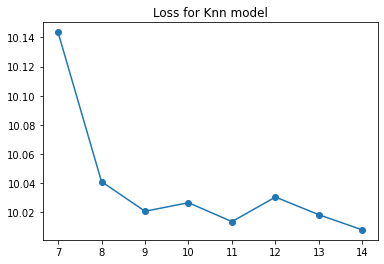

In [31]:
alpha_list=[i for i in range(7,15)]
loss_Knn_tot=[]
acc_Knn_tot=[]
for alpha in alpha_list:    
    print(alpha)
    model_Knn=KNeighborsRegressor(n_neighbors=alpha)
    loss_Knn,acc_Knn=model_result(model_Knn,X_train_vec,y_train_vec,X_test_vec,y_test_vec)
    loss_Knn_tot.append(loss_Knn)
    acc_Knn_tot.append(acc_Knn)

fig = plt.figure()
ax = plt.axes()
ax.scatter(alpha_list,loss_Knn_tot)
ax.plot(alpha_list,loss_Knn_tot) 
plt.title("Loss for Knn model")
plt.show()


In [61]:
model_Knn=KNeighborsRegressor(n_neighbors=np.argmin(np.array(loss_Knn_tot))+7)
loss_Knn,acc_Knn=model_result(model_Knn,X_train_vec,y_train_vec,X_test_vec,y_test_vec)
print(loss_Knn,acc_Knn)
loss_Knn_num,acc_Knn_num=model_result(model_Knn,X_train_num_vec,y_train_vec,X_test_num_vec,y_test_vec)
print(loss_Knn_num,acc_Knn_num)

10.042338804606793 0.28482639771732066
9.099029107928168 0.34160145398385927


10
11
12
13
14
15
16
17
18
19


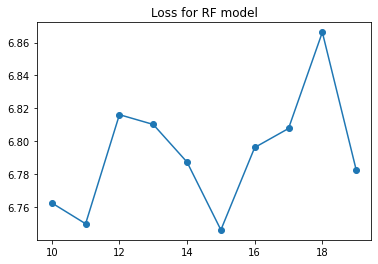

In [33]:
alpha_list=[i for i in range(10,20)]
loss_RF_tot=[]
acc_RF_tot=[]
for alpha in alpha_list:    
    print(alpha)
    model_RF=RandomForestRegressor(max_depth=alpha)
    loss_RF,acc_RF=model_result(model_RF,X_train_vec,y_train_vec,X_test_vec,y_test_vec)
    loss_RF_tot.append(loss_RF)
    acc_RF_tot.append(acc_RF)
    
fig = plt.figure()
ax = plt.axes()
ax.scatter(alpha_list,loss_RF_tot)
ax.plot(alpha_list,loss_RF_tot) 
plt.title("Loss for RF model")
plt.show()

In [70]:
model_RF=RandomForestRegressor(max_depth=np.argmin(np.array(loss_RF_tot))+10)
loss_RF,acc_RF=model_result(model_RF,X_train_vec,y_train_vec,X_test_vec,y_test_vec)
print(loss_RF,acc_RF)
loss_RF_num,acc_RF_num=model_result(model_RF,X_train_num_vec,y_train_vec,X_test_num_vec,y_test_vec)
print(loss_RF_num,acc_RF_num)

6.75432004595493 0.13152715390193143
6.665527210403895 0.13174374476179715


In [ ]:
# Load data
eval_data = pd.read_csv("data/evaluation.csv")

# Pre-process the traning data
label = "text"
eval_data[label] = eval_data[label].map(lambda x: str.split(x, sep=" "))


label = "urls"
eval_data[label] = eval_data[label].map(lambda x: [] if x=="[]" else [str.strip(url) for url in str.split(x[1:-1], sep=",")])
eval_data[label+"_count"] = eval_data[label].map(lambda x: len(x))


label = "hashtags"
eval_data[label] = eval_data[label].map(lambda x: [] if x=="[]" else [str.strip(tag) for tag in str.split(x[1:-1], sep=",")])
eval_data[label+"_count"] = eval_data[label].map(lambda x: len(x))



# Treatment of time
# The time relative to the election (month and yday), day in the week, 
# and the hour all affect the number of retweets.
eval_data["time"] = eval_data["timestamp"].map(lambda x: time.gmtime(x//1000))
# Only 2380 tweets are not posted in 2022, so we ignore the year
# eval_data["year"] = eval_data["timestamp"].map(lambda x: x.tm_year)
eval_data["month"] = eval_data["time"].map(lambda x: x.tm_mon)
eval_data["wday"] = eval_data["time"].map(lambda x: x.tm_wday)
eval_data["hour"] = eval_data["time"].map(lambda x: x.tm_hour)


# We drop the following data:
# @TweetID: useless
# @mentions: none of the mentions in the eval data are not null
# @mentions_count
# @urls: we use urls_count instead

eval_data.drop(labels=["time", "mentions", "urls"], axis=1, inplace=True)
eval_data.head(5)

,text,favorites_count,followers_count,statuses_count,friends_count,verified,hashtags,timestamp,TweetID,urls_count,hashtags_count,month,wday,hour
0,"[descendue, pourcentage, vote]",0,85,4442,327,0,"['presidentielle2022', 'hidalgo']",1647607994000,1184643,0,2,3,4,12
1,"[photo, demande, arbre, généalogique]",0,427,33282,443,0,[],1647601275000,1199190,0,0,3,4,11
2,"[dossiers, promis, poste, gars, vraiment, fiable]",6,1127,13111,1596,0,['macron'],1646900684000,917372,0,1,3,3,8
3,"[lol, cas, faut, second, tour, macron, sortir,...",2,1699,25760,2036,0,[],1647161294000,731754,1,0,3,6,8
4,"[zemmour, putain, discours, propagandiste, lit...",0,249,20718,369,0,[],1647724874000,1400049,2,0,3,5,21


In [ ]:
X_eval = eval_data.drop(labels=["TweetID"], axis=1)
    
standardise(X_eval,["favorites_count","followers_count","statuses_count","friends_count","urls_count","hashtags_count","verified","timestamp","month","wday","hour"])

# split the table into 2 parts: one with the text and the other with the numbers
X_eval_num=X_eval.drop(["text", "hashtags"], axis=1)


X_eval_text=X_eval[["text", "hashtags"]]

X_eval_num_vec=X_eval_num.values
X_eval_num_vec.shape

(117990, 11)

In [ ]:
# text to vector
eval_text_tensor=torch.Tensor(text2vec(X_eval_text["text"], model=model_text128))

# hashtags to vector
eval_tags_tensor=torch.Tensor(text2vec(X_eval_text["hashtags"], model=model_text128))

# combine the two vectors
X_eval_text_tensor = torch.cat((eval_text_tensor, eval_tags_tensor), axis=1)

In [ ]:
X_eval_num_vec=X_eval_num.to_numpy()
X_eval_text_vec=X_eval_text_tensor.numpy()
X_eval_vec=np.hstack([X_eval_num_vec,X_eval_text_vec])

X_eval_num_tensor=torch.Tensor(X_eval_num.values)

X_eval_tensor=torch.cat((X_eval_num_tensor, X_eval_text_tensor), axis=1)

print(X_eval_num_tensor.shape)
print(X_eval_text_tensor.shape)
print(X_eval_tensor.shape)

torch.Size([117990, 11])
torch.Size([117990, 256])
torch.Size([117990, 267])


In [822]:
model_RF=RandomForestRegressor(max_depth=np.argmin(np.array(loss_RF_tot))+10)
model_RF.fit(np.concatenate((X_train_num_vec,X_test_num_vec)), np.concatenate((y_train_vec, y_test_vec)))
pred_RF = model_RF.predict(X_eval_num_vec)

def write_result(filename,results):
    with open(filename, 'w',newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["TweetID", "retweets_count"])
        for index, prediction in enumerate(results):
            writer.writerow([str(eval_data['TweetID'].iloc[index]) , str(int(np.round(prediction)))])
            
print(pred_RF.shape)      
write_result("data/RF_predictions.txt", pred_RF)

KeyboardInterrupt: 

In [12]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature=6, output_size=10):
        super(CNN, self).__init__()
        #insert your code here
        K=5 #Kernel size
        self.n_feature = n_feature
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=n_feature, kernel_size=K)
        # self.conv2 = nn.Conv1d(n_feature, n_feature, kernel_size=K)
        self.fc1 = nn.Linear(n_feature*31, output_size)
        self.dropout = nn.Dropout(p=0.5)
        # self.batchnorm = nn.BatchNorm1d(20, momentum=0.1)
        
        
    def forward(self, x, verbose=False):
        #initial dimensions for x will be [24, 256]
        #insert your code here
        x=x.unsqueeze(dim=1) # [24, 1, 128]
        b = len(x)
        x = self.conv1(x) #[24, 6, 124]
        x = F.relu(x)
        x = F.max_pool1d(x, kernel_size=4) #[24, 6, 31]
        # x = self.conv2(x)  # [24, 6, 27]
        # x = F.relu(x)
        # x = F.max_pool1d(x, kernel_size=4) #[24, 6, 6]
        # print("x.shape",x.shape) 
        x = x.reshape(-1, self.n_feature*31) 
        x = self.fc1(x)
        x = self.dropout(x)

        return x
    
    
def initilize_model_CNN(input_size, 
                    n_feature=5,
                    output_size=10,
                    learning_rate=0.01):

    cnn_model = CNN(input_size=input_size,
                    n_feature=n_feature,
                    output_size=output_size)
    
    cnn_model.to(device)

    optimizer = optim.Adam(cnn_model.parameters(),
                           lr=learning_rate)
    
    # L1loss is the MAE loss
    loss_function = nn.L1Loss()
    
    return cnn_model, optimizer, loss_function

In [27]:
def train(model, optimizer, train_loader, epoch=100):
    log_interval= max(epoch//10, 1)
    #set model in train mode
    model.train() 
    t0_epoch = time.time()
    for epoch_i in range(epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            # print(output.shape)
            # print("data",data.shape)
            # print(output.shape, target.shape)
            loss = F.l1_loss(output, target)
            
            loss.backward()
            optimizer.step()
            
        if epoch_i % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} \ttime_elapsed: {:^9.2f}'.format(
                epoch, epoch_i+1, epoch,
                100. * (epoch_i+1) / epoch, loss.item(), time.time()-t0_epoch))
                

def evaluate(model, loss_function, eval_loader):

    #set model in eval mode
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []
    # For each batch in our validation set...
    for step, (data, target) in enumerate(eval_loader):
        # print(data.shape, target.shape)
        # break
        # Compute logits
        with torch.no_grad():
            data, target = data.to(device), target.to(device)
            output = model(data)

        # Compute loss
        loss = loss_function(output, target)
        val_loss.append(loss)

        # Calculate the accuracy rate
        accuracy = (output == target).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [14]:
batch_size = 24
dataset_train_text = TensorDataset(X_train_text_tensor.to(device), y_train_tensor.to(device))
X_train_loader_text = DataLoader(dataset=dataset_train_text, batch_size=batch_size, shuffle=True)

dataset_train_tweet = TensorDataset(train_text_tensor.to(device), y_train_tensor.to(device))
X_train_loader_tweet = DataLoader(dataset=dataset_train_tweet , batch_size=batch_size, shuffle=True)

dataset_train_tags = TensorDataset(train_tags_tensor.to(device), y_train_tensor.to(device))
X_train_loader_tags = DataLoader(dataset=dataset_train_tags, batch_size=batch_size, shuffle=True)


In [15]:
input_size = X_train_text_vec.shape[1]
cnn_model, optimizer, loss_function = initilize_model_CNN(input_size=input_size,
                                                      n_feature=6,
                                                      output_size=1,
                                                      learning_rate=1e-5)
print(len(dataset_train_text))


247778


In [17]:
# train(cnn_model, optimizer, train_loader=X_train_loader_text, epoch=1)

In [19]:
dataset_test_text = TensorDataset(X_test_text_tensor[:400].to(device), y_test_tensor[:400].to(device))
X_test_loader_text = DataLoader(dataset=dataset_test_text, shuffle=True)

dataset_test_tweet = TensorDataset(test_text_tensor.to(device), y_test_tensor.to(device))
X_test_loader_tweet = DataLoader(dataset=dataset_test_tweet, shuffle=True)

dataset_test_tags = TensorDataset(test_tags_tensor.to(device), y_test_tensor.to(device))
X_test_loader_tags = DataLoader(dataset=dataset_test_tags, shuffle=True)

# evaluate(cnn_model, loss_function, eval_loader=X_test_loader_text)

In [20]:
# Here we define the full internet
class FNN(nn.Module):
    def __init__(self, 
                 input_num_size,
                 input_tweet_size,  
                 input_tags_size, 
                 dense_layers, 
                 output_tweet_size, 
                 output_tags_size, 
                 dropout):
        super(FNN, self).__init__()
        
        self.input_num_size = input_num_size
        self.input_tweet_size = input_tweet_size
        self.input_tags_size = input_tags_size
        self.tot_size = input_num_size + output_tweet_size + output_tags_size
        
        self.CNN_tweet = CNN(input_size=input_tweet_size, output_size=output_tweet_size)
        self.CNN_tags = CNN(input_size=input_tweet_size, output_size=output_tags_size)
        
        self.dense1 = nn.Linear(self.tot_size, dense_layers[0])
        self.dense2 = nn.Linear(dense_layers[0], dense_layers[1])
        self.dense3 = nn.Linear(dense_layers[1], 1)
        
        self.dropout = nn.Dropout(p=dropout)
        self.batchnorm= nn.BatchNorm1d(dense_layers[0])

    def forward(self, x, verbose=False):
        
        # assert(self.tot_size==len(x))
        # print(x.shape)
        x_num = x[:,:self.input_num_size]
        x_tweet = x[:,self.input_num_size: self.input_num_size + self.input_tweet_size]
        x_tags = x[:,self.input_num_size + self.input_tweet_size:]
        
        x_tweet = self.CNN_tweet(x_tweet)

        x_tags= self.CNN_tags(x_tags)
 
        x_dense = torch.cat((x_num, x_tweet, x_tags), axis=1)
        
        x_dense = self.dense1(x_dense)
        x_dense = F.relu(x_dense)
        
        x_dense = self.dropout(x_dense)
        x_dense = self.batchnorm(x_dense)
        
        x_dense = self.dense2(x_dense)
        
        res = self.dense3(F.relu(x_dense))
        return F.relu(res)

In [21]:
def initilize_model_FNN(input_num_size,
                        input_tweet_size,  
                        input_tags_size, 
                        dense_layers=[50, 10], 
                        output_tweet_size=10, 
                        output_tags_size=5, 
                        dropout=0.5,
                        learning_rate=1e-3):

    fnn_model = FNN(input_num_size=input_num_size,
                    input_tweet_size=input_tweet_size,  
                    input_tags_size=input_tags_size, 
                    dense_layers=dense_layers, 
                    output_tweet_size=output_tweet_size, 
                    output_tags_size=output_tags_size, 
                    dropout=dropout)
    
    fnn_model.to(device)

    optimizer = optim.Adam(cnn_model.parameters(),
                           lr=learning_rate)
    
    # L1loss is the MAE loss
    loss_function = nn.L1Loss()
    
    return fnn_model, optimizer, loss_function

In [28]:

batch_size=24
dataset_train = TensorDataset(X_train_tensor.to(device), y_train_tensor.to(device))
X_train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)


input_num_size = X_train_num_vec.shape[1]
input_tweet_size = X_train_tweet_vec.shape[1]
input_tags_size = X_train_tags_vec.shape[1]
fnn_model, optimizer, loss_function = initilize_model_FNN(input_num_size, 
                                                          input_tweet_size, 
                                                          input_tags_size, 
                                                          output_tweet_size=10, 
                                                          output_tags_size=5, 
                                                          dropout=0.7,
                                                          learning_rate=1e-5)

In [29]:
print(input_tags_size)
print(len(X_train_loader)*batch_size)
train(fnn_model, optimizer, train_loader=X_train_loader, epoch=10)

128
247800
Train Epoch: 10 [1/10 (10%)]	Loss: 1.560114 	time_elapsed:   20.54  
Train Epoch: 10 [2/10 (20%)]	Loss: 0.000000 	time_elapsed:   41.37  
Train Epoch: 10 [3/10 (30%)]	Loss: 0.927063 	time_elapsed:   62.35  


KeyboardInterrupt: 

In [30]:
dataset_test = TensorDataset(X_test_tensor.to(device), y_test_tensor.to(device))
X_test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True)

evaluate(fnn_model, loss_function, eval_loader=X_test_loader)

(15.624272, 42.92843691148776)

In [757]:
def predict(model, eval_loader):

    #set model in eval mode
    model.eval()

    # Tracking variables
    preds=[]
    
    # For each batch in our validation set...
    for step, (data,) in enumerate(eval_loader):
        data = data.to(device)
        with torch.no_grad():
            output = model(data)
            preds.append(output)

    return np.array(preds)

In [1162]:
dataset_eval = TensorDataset(X_eval_tensor[:10000].to(device))
print(X_eval_tensor.shape)
X_eval_loader = DataLoader(dataset=dataset_eval)

preds = predict(fnn_model, X_eval_loader)


torch.Size([117990, 267])


In [1163]:
preds = np.array([int(np.round(num)) for num in preds ])
# write_result("data/FNN_predictions.txt", preds)
print(np.mean(preds))

0.0533


In [1164]:
train_data["retweets_count"].median()

1.0